>
> # Shared rides with pricing

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
  
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  

 



In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [3]:
import pandas as pd

In [4]:
import ExMAS

In [5]:
params = get_config('../../data/config/delft.json')  # load configuration

In [6]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 8 # reuqests (and passengers)
params.nV = 8 # vehicles

In [7]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

In [8]:
inData = load_G(inData, params)  # load network graph 

In [9]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [10]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

13-02-23 12:27:11-INFO-Initializing pairwise trip shareability between 8 and 8 trips.
13-02-23 12:27:11-INFO-creating combinations
13-02-23 12:27:11-INFO-56	 nR*(nR-1)
13-02-23 12:27:11-INFO-Reduction of feasible pairs by 98.21%
13-02-23 12:27:11-INFO-Degree 2 	Completed
13-02-23 12:27:11-INFO-trips to extend at degree 2 : 3
13-02-23 12:27:11-INFO-At degree 2 feasible extensions found out of 0 searched
13-02-23 12:27:11-INFO-Degree 3 	Completed
13-02-23 12:27:11-INFO-No more trips to exted at degree 3


In [11]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

13-02-23 12:27:11-INFO-Matching 8 trips to 11 rides in order to min u_pax
13-02-23 12:27:11-INFO-Problem solution: Optimal. 
Total costs for single trips:             30 
reduced by matching to:                   29


In [12]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],2.52800,136,1,[2.528],"[0, 136]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 1436427106, 44821566]","[None, 0, 0]",node time req_id od 0 ...,136,1.36,2.05200,0.41040,1.64160
1,[1],3.20800,173,1,[3.208],"[44, 173]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 1435362459, 44847929]","[None, 1, 1]",node time req_id od 0 ...,173,1.73,2.60250,0.52050,2.08200
2,[2],5.63150,304,1,[5.6315],"[50, 304]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 4846026455, 1410536974]","[None, 2, 2]",node time req_id od 0 ...,304,3.04,4.56750,0.91350,3.65400
3,[3],1.51700,82,1,[1.517],"[93, 82]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 5124546092, 44850694]","[None, 3, 3]",node time req_id od 0 ...,82,0.82,1.23000,0.24600,0.98400
4,[4],4.96850,268,1,[4.9685],"[94, 268]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",1,"[None, 1402734964, 44828189]","[None, 4, 4]",node time req_id od 0 ...,268,2.68,4.03050,0.80610,3.22440
5,[5],4.15750,224,1,[4.1575],"[126, 224]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0,"[None, 44859593, 1552650472]","[None, 5, 5]",node time req_id od 0 ...,224,2.24,3.37350,0.67470,2.69880
6,[6],4.32250,233,1,[4.3225],"[156, 233]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1,"[None, 44768467, 44813588]","[None, 6, 6]",node time req_id od 0 NaN...,233,2.33,3.50700,0.70140,2.80560
7,[7],3.84300,207,1,[3.843],"[264, 207]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1,"[None, 44873992, 4555788280]","[None, 7, 7]",node time req_id od 0 ...,207,2.07,3.11850,0.62370,2.49480
8,"[0, 1]",5.10545,242,20,"[2.1370999999999998, 2.96835]","[18.0, 8, 128, 106]","[0, 1]","[0, 1]",2,8,...,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 1436427106, 1435362459, 44821566, 44847...","[None, 0, 1, 0, 1]",node time req_id od 0 ...,242,2.42,3.25815,0.65163,2.60652
9,"[1, 5]",6.27165,368,20,"[2.618, 3.65365]","[42.0, 86, 87, 195]","[1, 5]","[1, 5]",2,9,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",1,"[None, 1435362459, 44859593, 44847929, 1552650...","[None, 1, 5, 1, 5]",node time req_id od 0 ...,368,3.68,4.18320,0.83664,3.34656


In [13]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

13-02-23 12:27:12-INFO-Matching 8 trips to 11 rides in order to min u_pax
13-02-23 12:27:12-INFO-Problem solution: Optimal. 
Total costs for single trips:             30 
reduced by matching to:                   29
13-02-23 12:27:12-WARNING-Setting up 0.1h simulation at 2023-02-13 12:25:38 for 8 vehicles and 8 passengers in Delft, Netherlands
13-02-23 12:27:12-CRITICAL-this is request 0 with [0, 8, 10] available rides.
13-02-23 12:27:12-CRITICAL-ride 0 available [1]
13-02-23 12:27:12-CRITICAL-ride 8 available [1, 0]
13-02-23 12:27:12-CRITICAL-ride 10 available [0, 1]
13-02-23 12:27:12-CRITICAL-this is reuqest 0 with [0, 8, 10] still available rides.
13-02-23 12:27:12-CRITICAL-vehicle 1 has 3 choices
13-02-23 12:27:12-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 10 of degree 2, with travellers [1, 0].
13-02-23 12:27:12-CRITICAL-this is request 1 with [1, 8, 9, 10] available rides.
13-02-23 12:27:12-CRITICAL-ride 1 available [1]
13-02-23 12:27:12-CRITICAL-ride 8 not avai

In [31]:
inData.sblts.rides.nodes.to_list()[0][2]



44825205

In [32]:
dist_to_pick = []
veh_pos = []

In [33]:
sim.pax

{0: <MaaSSim.traveller.PassengerAgent at 0x21fe0c6d1b0>,
 1: <MaaSSim.traveller.PassengerAgent at 0x21fe0c6f550>,
 2: <MaaSSim.traveller.PassengerAgent at 0x21fe3093820>,
 3: <MaaSSim.traveller.PassengerAgent at 0x21fe3093fa0>,
 4: <MaaSSim.traveller.PassengerAgent at 0x21fe0ba8760>,
 5: <MaaSSim.traveller.PassengerAgent at 0x21fe0ba8ee0>,
 6: <MaaSSim.traveller.PassengerAgent at 0x21fe0ba9660>,
 7: <MaaSSim.traveller.PassengerAgent at 0x21fe0ba9de0>}

In [34]:
dist_to_pick



[]

In [35]:
dist_to_pick = []
veh_pos = [sim.vehs[i].veh.pos for i in sim.vehs]
for i in range(0, len(inData.sblts.rides.index)):
    pax_pos = inData.sblts.rides.iloc[i].nodes[1]
    dist_to_pi = max([sim.inData.skim[j][pax_pos] for j in veh_pos])/1000
    dist_to_pick.append(dist_to_pi)
inData.sblts.rides["dist_to_pick"] = dist_to_pick
inData.sblts.rides["total_dist"] = inData.sblts.rides["dist_to_pick"] + inData.sblts.rides["dist"]
#fuel = 1.5
price = 0.5 
penalty = 1
inData.sblts.rides["cost"] = inData.sblts.rides["dist_to_pick"].apply(lambda x : x*price)
inData.sblts.rides["profit"] = inData.sblts.rides["driver_revenue"] - inData.sblts.rides["cost"]

#inData.sblts.rides["all_cost"] =  inData.sblts.rides["cost"].apply(lambda x : x + penalty) # time and fuel are left

In [36]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,sim_schedule,ttrav,dist,fare,commission,driver_revenue,dist_to_pick,total_dist,cost,profit
0,[0],2.93200,158,1,[2.932],"[0, 158]",[0],[0],1,0,...,node time req_id od 0 ...,158,1.58,2.3790,0.47580,1.90320,4.476,6.056,2.2380,-0.33480
1,[1],3.68900,199,1,[3.689],"[26, 199]",[1],[1],1,1,...,node time req_id od 0 NaN...,199,1.99,2.9925,0.59850,2.39400,4.140,6.130,2.0700,0.32400
2,[2],5.89200,318,1,[5.8919999999999995],"[91, 318]",[2],[2],1,2,...,node time req_id od 0 ...,318,3.18,4.7790,0.95580,3.82320,3.970,7.150,1.9850,1.83820
3,[3],4.49850,243,1,[4.4985],"[261, 243]",[3],[3],1,3,...,node time req_id od 0 ...,243,2.43,3.6480,0.72960,2.91840,3.991,6.421,1.9955,0.92290
4,[4],7.74200,418,1,[7.742],"[286, 418]",[4],[4],1,4,...,node time req_id od 0 ...,418,4.18,6.2790,1.25580,5.02320,4.343,8.523,2.1715,2.85170
5,[5],2.59300,140,1,[2.593],"[299, 140]",[5],[5],1,5,...,node time req_id od 0 NaN...,140,1.40,2.1030,0.42060,1.68240,3.603,5.003,1.8015,-0.11910
6,[6],3.99750,216,1,[3.9974999999999996],"[304, 216]",[6],[6],1,6,...,node time req_id od 0 ...,216,2.16,3.2415,0.64830,2.59320,5.523,7.683,2.7615,-0.16830
7,[7],5.28450,285,1,[5.2844999999999995],"[320, 285]",[7],[7],1,7,...,node time req_id od 0 N...,285,2.85,4.2870,0.85740,3.42960,5.739,8.589,2.8695,0.56010
8,"[0, 3]",6.71230,447,20,"[2.83465, 3.8776499999999996]","[35.0, 191, 31, 225]","[0, 3]","[0, 3]",2,8,...,node time req_id od 0 ...,447,4.47,4.2189,0.84378,3.37512,4.476,8.946,2.2380,1.13712
9,"[2, 3]",9.99845,634,20,"[5.595274999999999, 4.403174999999999]","[33.5, 285, 152, 197]","[2, 3]","[2, 3]",2,9,...,node time req_id od 0 ...,634,6.34,5.8989,1.17978,4.71912,3.970,10.310,1.9850,2.73412


In [34]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

01-02-23 10:27:40-WARNING-Setting up 0.1h simulation at 2023-02-01 10:20:42 for 8 vehicles and 8 passengers in Delft, Netherlands
01-02-23 10:27:40-CRITICAL-this is request 0 with [0, 8, 9, 11, 12] available rides.
01-02-23 10:27:40-CRITICAL-ride 0 available [1]
01-02-23 10:27:40-CRITICAL-ride 8 available [1, 0]
01-02-23 10:27:40-CRITICAL-ride 9 available [1, 0]
01-02-23 10:27:40-CRITICAL-ride 11 available [1, 0]
01-02-23 10:27:40-CRITICAL-ride 12 available [1, 0]
01-02-23 10:27:40-CRITICAL-this is reuqest 0 with [0, 8, 9, 11, 12] still available rides.
01-02-23 10:27:40-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 8 of degree 2, with travellers [0, 1].
01-02-23 10:27:40-CRITICAL-this is request 1 with [1, 8, 13, 14] available rides.
01-02-23 10:27:40-CRITICAL-ride 1 available [1]
01-02-23 10:27:40-CRITICAL-ride 8 not available [5, 1]
01-02-23 10:27:40-CRITICAL-ride 13 available [1, 0]
01-02-23 10:27:40-CRITICAL-ride 14 available [1, 0]
01-02-23 10:27:40-CRITICAL-this i

In [35]:
my_choice = inData.sblts.rides[inData.sblts.rides["profit"]==inData.sblts.rides["profit"].max()].squeeze()

In [36]:
my_choice

indexes                                                       [0, 1]
u_pax                                                       17.60185
u_veh                                                            982
kind                                                              20
u_paxes                                  [8.7843, 8.817549999999999]
times                                        [-160.0, 369, 185, 428]
indexes_orig                                                  [0, 1]
indexes_dest                                                  [0, 1]
degree                                                             2
index                                                              8
PassHourTrav_ns                                                 1031
row                         [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
selected                                                           0
nodes              [None, 5198175608, 44866501, 565046992, 551067...
req_id                            

In [37]:
inData.sblts.rides.keys()

Index(['indexes', 'u_pax', 'u_veh', 'kind', 'u_paxes', 'times', 'indexes_orig',
       'indexes_dest', 'degree', 'index', 'PassHourTrav_ns', 'row', 'selected',
       'nodes', 'req_id', 'sim_schedule', 'ttrav', 'dist', 'fare',
       'commission', 'driver_revenue', 'dist_to_pick', 'total_dist', 'cost',
       'profit'],
      dtype='object')

In [100]:
sim = simulate(params = params, inData = inData, logger_level = logging.CRITICAL) # simulate

01-02-23 13:51:04-CRITICAL-this is request 0 with [0, 8, 13, 19] available rides.
01-02-23 13:51:04-CRITICAL-ride 0 available [1]
01-02-23 13:51:04-CRITICAL-ride 8 available [1, 0]
01-02-23 13:51:04-CRITICAL-ride 13 available [0, 1]
01-02-23 13:51:04-CRITICAL-ride 19 available [0, 1, 0]
01-02-23 13:51:04-CRITICAL-this is reuqest 0 with [0, 8, 13, 19] still available rides.
01-02-23 13:51:04-CRITICAL-vehicle 1 has 4 choices
01-02-23 13:51:04-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 8 of degree 2, with travellers [0, 3].
01-02-23 13:51:04-CRITICAL-this is request 1 with [1, 9, 10, 18] available rides.
01-02-23 13:51:04-CRITICAL-ride 1 available [1]
01-02-23 13:51:04-CRITICAL-ride 9 not available [1, 3]
01-02-23 13:51:04-CRITICAL-ride 10 available [1, 0]
01-02-23 13:51:04-CRITICAL-ride 18 available [0, 1]
01-02-23 13:51:04-CRITICAL-this is reuqest 1 with [1, 10, 18] still available rides.
01-02-23 13:51:04-CRITICAL-vehicle 5 has 3 choices
01-02-23 13:51:04-CRITICAL-veh

simulate

In [38]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

01-02-23 10:27:51-WARNING-Setting up 0.1h simulation at 2023-02-01 10:20:42 for 8 vehicles and 8 passengers in Delft, Netherlands
01-02-23 10:27:52-CRITICAL-this is request 0 with [0, 8, 9, 11, 12] available rides.
01-02-23 10:27:52-CRITICAL-ride 0 available [1]
01-02-23 10:27:52-CRITICAL-ride 8 available [1, 0]
01-02-23 10:27:52-CRITICAL-ride 9 available [1, 0]
01-02-23 10:27:52-CRITICAL-ride 11 available [1, 0]
01-02-23 10:27:52-CRITICAL-ride 12 available [1, 0]
01-02-23 10:27:52-CRITICAL-this is reuqest 0 with [0, 8, 9, 11, 12] still available rides.
01-02-23 10:27:52-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 8 of degree 2, with travellers [0, 1].
01-02-23 10:27:52-CRITICAL-this is request 1 with [1, 8, 13, 14] available rides.
01-02-23 10:27:52-CRITICAL-ride 1 available [1]
01-02-23 10:27:52-CRITICAL-ride 8 not available [5, 1]
01-02-23 10:27:52-CRITICAL-ride 13 available [1, 0]
01-02-23 10:27:52-CRITICAL-ride 14 available [1, 0]
01-02-23 10:27:52-CRITICAL-this i

In [78]:
pd.DataFrame(sim.vehs[8].myrides)

,veh,pos,t,event,paxes
0,8,1.957359e+09,0.0,STARTS_DAY,[]
1,8,1.957359e+09,0.0,OPENS_APP,[]
2,8,1.957359e+09,171.0,RECEIVES_REQUEST,[]
3,8,1.957359e+09,186.0,ACCEPTS_REQUEST,[]
4,8,1.957359e+09,206.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,8,1.957359e+09,334.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,8,1.570983e+09,649.0,ARRIVES_AT_PICKUP,[]
7,8,1.570983e+09,649.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,8,1.570983e+09,679.0,DEPARTS_FROM_PICKUP,[4]
9,8,4.472907e+07,730.0,ARRIVES_AT_PICKUP,[4]


In [40]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: position, dtype: int64

In [41]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,5.650470e+08,0.0,STARTS_DAY,[]
1,1,5.650470e+08,0.0,OPENS_APP,[]
2,1,5.650470e+08,0.0,RECEIVES_REQUEST,[]
3,1,5.650470e+08,15.0,ACCEPTS_REQUEST,[]
4,1,5.650470e+08,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,5.650470e+08,218.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,5.198176e+09,545.0,ARRIVES_AT_PICKUP,[]
7,1,5.198176e+09,545.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,5.198176e+09,575.0,DEPARTS_FROM_PICKUP,[0]
9,1,4.485474e+07,746.0,ARRIVES_AT_PICKUP,[0]


In [42]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id


In [43]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,5198175608,0,STARTS_DAY,NaN
1,0,5198175608,0,REQUESTS_RIDE,NaN
2,0,5198175608,0,RECEIVES_OFFER,NaN
3,0,5198175608,15,ACCEPTS_OFFER,NaN
4,0,5198175608,35,ARRIVES_AT_PICKUP,1.0
5,0,5198175608,183,RECEIVES_OFFER,1.0
6,0,5198175608,545,MEETS_DRIVER_AT_PICKUP,1.0
7,0,5198175608,575,DEPARTS_FROM_PICKUP,1.0
8,0,565046992,1336,ARRIVES_AT_DROPOFF,1.0
9,0,565046992,1346,SETS_OFF_FOR_DEST,NaN


In [44]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,5.650470e+08,0.0,STARTS_DAY,[]
1,1,5.650470e+08,0.0,OPENS_APP,[]
2,1,5.650470e+08,0.0,RECEIVES_REQUEST,[]
3,1,5.650470e+08,15.0,ACCEPTS_REQUEST,[]
4,1,5.650470e+08,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,5.650470e+08,218.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,5.198176e+09,545.0,ARRIVES_AT_PICKUP,[]
7,1,5.198176e+09,545.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,5.198176e+09,575.0,DEPARTS_FROM_PICKUP,[0]
9,1,4.485474e+07,746.0,ARRIVES_AT_PICKUP,[0]


<AxesSubplot:>

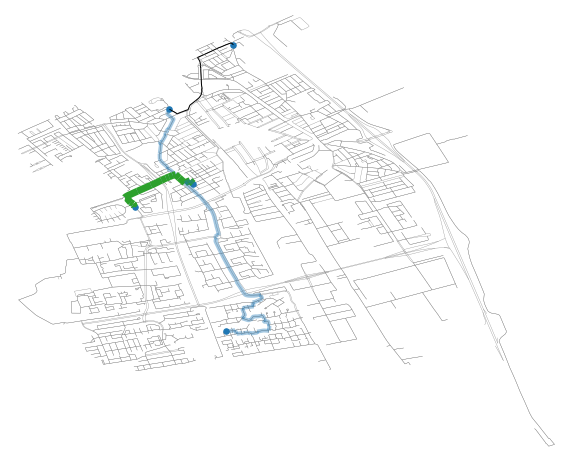

In [45]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----